# Artist Collaboration Graph

The objective of this file is to extract relevant insights from the spotify dataset, organized as a graph, where the nodes are artists and the edges are collaborations between them (including features, such as th popularity of the song, the duration, etc.). The plan is to extract, for example, the following insights:
- Genre Detection: Identify clusters.
- Most collaborative artists: Using Degree Centrality.
- Bridge artists between genres: Using Betweenness Centrality.

## Load the dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/joaolopes2003/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1


In [2]:
import pandas as pd
import os

# Assuming KaggleHub gives you the CSV path in 'path'
file_path = os.path.join(path, "dataset.csv")  # Adjust if the filename differs
df = pd.read_csv(file_path)

# Show the first few rows
print(df.columns)

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


In [3]:
df.head(3)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,...,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,...,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,...,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


## Data Preprocessing

In [6]:
# Filter songs with no artists
df = df[df['artists'].notna() & (df['artists'] != '')]

# Convert semicolon-separated artist strings into Python lists
df['artists'] = df['artists'].apply(lambda x: [artist.strip() for artist in x.split(';') if artist.strip()])

In [7]:
df.head(3)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,[Gen Hoshino],Comedy,Comedy,73,230666,False,0.676,0.461,...,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,[Ben Woodward],Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,...,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,"[Ingrid Michaelson, ZAYN]",To Begin Again,To Begin Again,57,210826,False,0.438,0.359,...,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


## Creating the Graph

In [9]:
import networkx as nx

# Initialize MultiGraph (undirected graph with multiple edges allowed)
G = nx.MultiGraph()

for _, row in df.iterrows():
    artists = row['artists']
    
    # Get song metadata
    popularity = row.get('popularity', 0)
    song_info = {
        'track_name': row.get('track_name'),
        'album_name': row.get('album_name'),
        'duration_ms': row.get('duration_ms'),
        'popularity': popularity,
        'weight': popularity  # 💡 this is the edge weight
    }

    if len(artists) > 1:
        # Add one edge per artist pair (for each song)
        for i in range(len(artists)):
            for j in range(i + 1, len(artists)):
                G.add_edge(artists[i], artists[j], **song_info)
    else:
        # Solo song → self-loop
        artist = artists[0]
        G.add_edge(artist, artist, **song_info)

## Graph Analysis

### Basic Insights

In [14]:
print("Number of artists:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Total number of songs:", len(df))
print("Number of solo songs:", sum(1 for u, v in G.edges() if u == v))

# Number of solo and collaborative artists
solo = sum(1 for node in G.nodes if G.has_edge(node, node))
collab = G.number_of_nodes() - solo
print(f"Solo artists: {solo}, Collaborating artists: {collab}")

Number of artists: 29858
Number of edges: 157180
Total number of songs: 113999
Number of solo songs: 83924
Solo artists: 15038, Collaborating artists: 14820


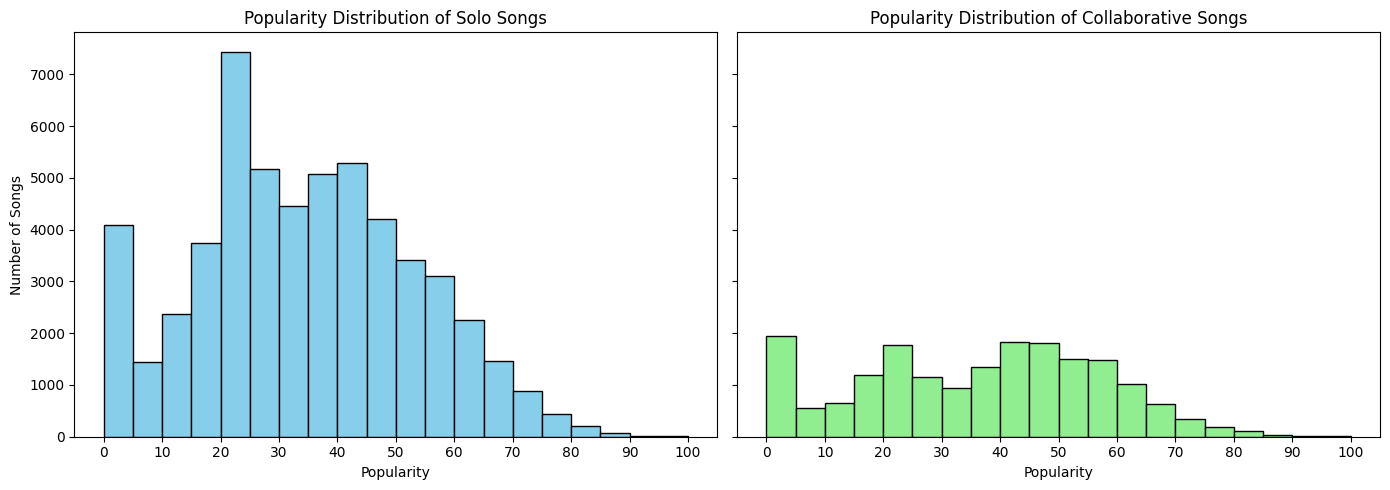

In [15]:
import matplotlib.pyplot as plt

solo_popularity = []
collab_popularity = []

# Track seen songs by their unique name
seen_tracks = set()

for u, v, data in G.edges(data=True):
    track_name = data.get('track_name')
    popularity = data.get('popularity', 0)

    # Skip if we've already counted this track
    if track_name in seen_tracks:
        continue
    seen_tracks.add(track_name)

    if u == v:
        solo_popularity.append(popularity)
    else:
        collab_popularity.append(popularity)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(solo_popularity, bins=range(0, 105, 5), color='skyblue', edgecolor='black')
axes[0].set_title('Popularity Distribution of Solo Songs')
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Number of Songs')
axes[0].set_xticks(range(0, 101, 10))

axes[1].hist(collab_popularity, bins=range(0, 105, 5), color='lightgreen', edgecolor='black')
axes[1].set_title('Popularity Distribution of Collaborative Songs')
axes[1].set_xlabel('Popularity')
axes[1].set_xticks(range(0, 101, 10))

plt.tight_layout()
plt.show()

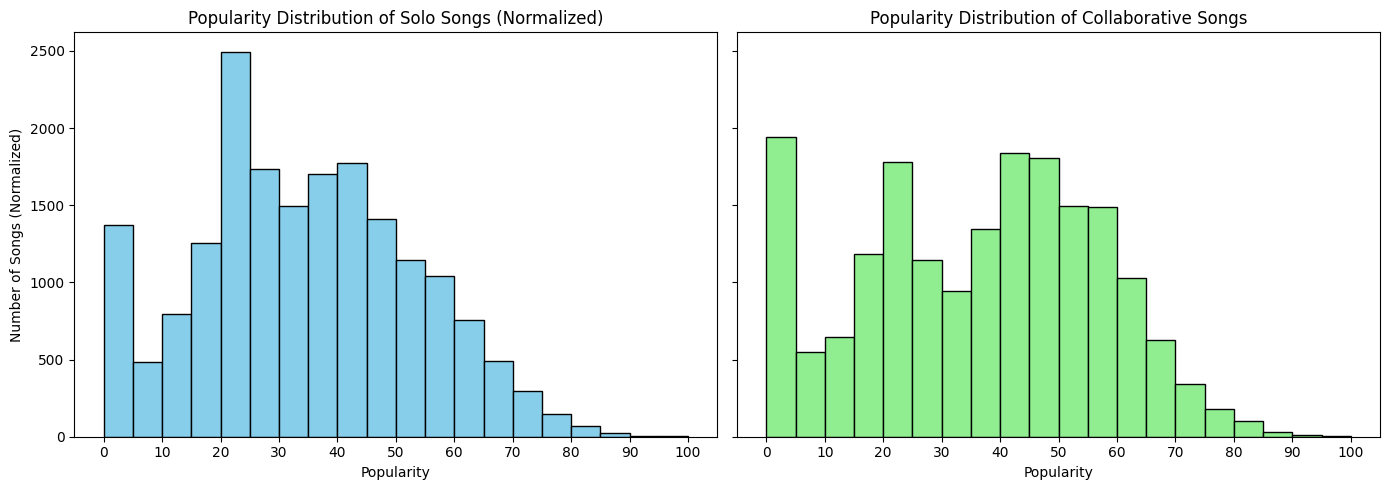

In [16]:
import matplotlib.pyplot as plt
import numpy as np

solo_popularity = []
collab_popularity = []

seen_tracks = set()

for u, v, data in G.edges(data=True):
    track_name = data.get('track_name')
    popularity = data.get('popularity', 0)

    if track_name in seen_tracks:
        continue
    seen_tracks.add(track_name)

    if u == v:
        solo_popularity.append(popularity)
    else:
        collab_popularity.append(popularity)

# Calculate normalization factor
num_solo = len(solo_popularity)
num_collab = len(collab_popularity)
normalization_factor = num_solo / num_collab if num_collab != 0 else 1

# Define bins
bins = range(0, 105, 5)

# Calculate histograms
solo_counts, _ = np.histogram(solo_popularity, bins=bins)
collab_counts, _ = np.histogram(collab_popularity, bins=bins)

# Normalize solo counts
solo_counts_normalized = solo_counts / normalization_factor

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(bins[:-1], solo_counts_normalized, width=5, color='skyblue', edgecolor='black', align='edge')
axes[0].set_title('Popularity Distribution of Solo Songs (Normalized)')
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Number of Songs (Normalized)')
axes[0].set_xticks(range(0, 101, 10))

axes[1].bar(bins[:-1], collab_counts, width=5, color='lightgreen', edgecolor='black', align='edge')
axes[1].set_title('Popularity Distribution of Collaborative Songs')
axes[1].set_xlabel('Popularity')
axes[1].set_xticks(range(0, 101, 10))

plt.tight_layout()
plt.show()

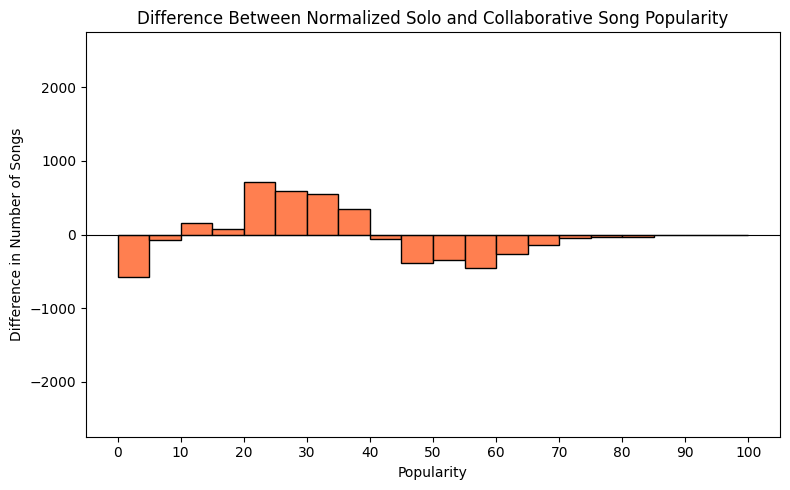

In [18]:
import matplotlib.pyplot as plt
import numpy as np

solo_popularity = []
collab_popularity = []

seen_tracks = set()

for u, v, data in G.edges(data=True):
    track_name = data.get('track_name')
    popularity = data.get('popularity', 0)

    if track_name in seen_tracks:
        continue
    seen_tracks.add(track_name)

    if u == v:
        solo_popularity.append(popularity)
    else:
        collab_popularity.append(popularity)

# Calculate normalization factor
num_solo = len(solo_popularity)
num_collab = len(collab_popularity)
normalization_factor = num_solo / num_collab if num_collab != 0 else 1

# Define bins
bins = range(0, 105, 5)

# Calculate histograms
solo_counts, _ = np.histogram(solo_popularity, bins=bins)
collab_counts, _ = np.histogram(collab_popularity, bins=bins)

# Normalize solo counts
solo_counts_normalized = solo_counts / normalization_factor

# Calculate difference
difference = solo_counts_normalized - collab_counts

# Determine y-axis limits based on previous plots
max_count = max(solo_counts_normalized.max(), collab_counts.max())
y_lim_upper = max_count * 1.1  # Add 10% padding
y_lim_lower = -y_lim_upper     # Symmetric lower bound for differences

# Plotting the difference
plt.figure(figsize=(8,5))
plt.bar(bins[:-1], difference, width=5, color='coral', edgecolor='black', align='edge')
plt.title('Difference Between Normalized Solo and Collaborative Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Difference in Number of Songs')
plt.xticks(range(0, 101, 10))
plt.axhline(0, color='black', linewidth=0.8)
plt.ylim(y_lim_lower, y_lim_upper)
plt.tight_layout()
plt.show()

### Advanced Features

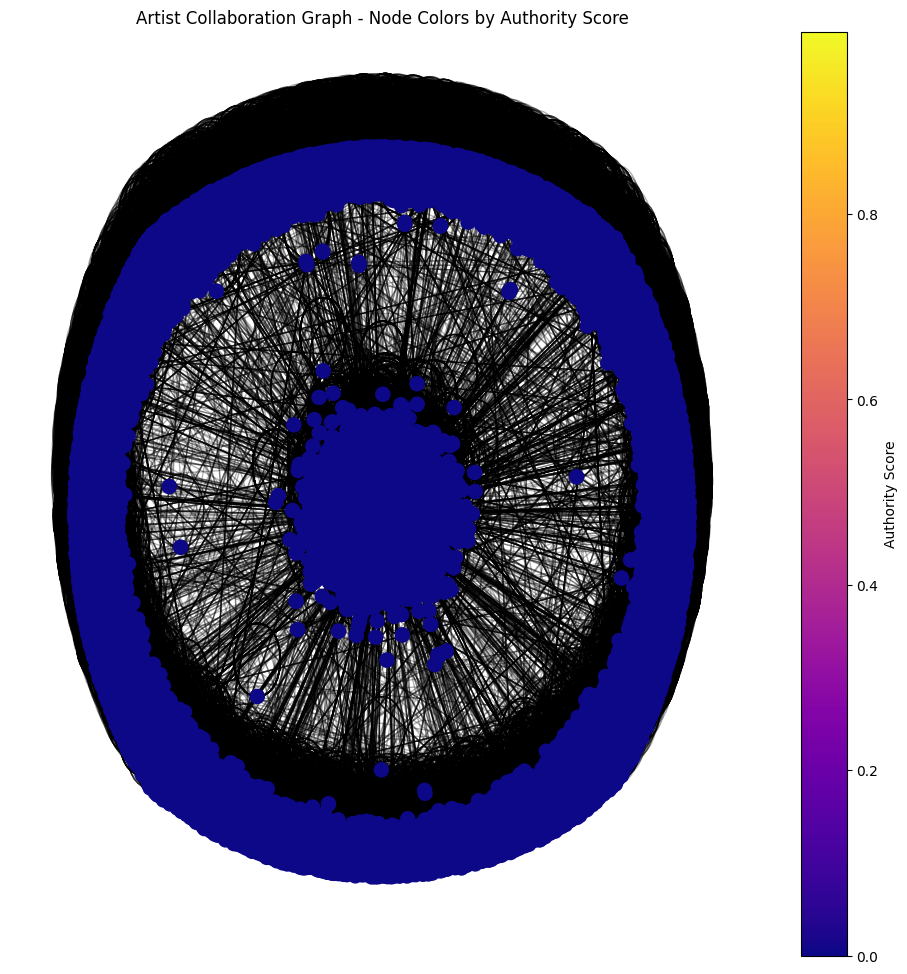

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Run HITS algorithm
hits_hubs, hits_authorities = nx.hits(G, max_iter=1000, normalized=True)

# Add authority score as node attribute for visualization
nx.set_node_attributes(G, hits_authorities, 'authority')

# Visualize graph with node color mapped to authority scores
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, seed=42)  # layout for node positioning

# Node colors based on authority scores (normalized 0-1)
node_colors = [hits_authorities[node] for node in G.nodes()]

nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.plasma, node_size=100)
edges = nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.colorbar(nodes, label='Authority Score')
plt.title('Artist Collaboration Graph - Node Colors by Authority Score')
plt.axis('off')
plt.show()


In [20]:
import community as community_louvain

# Convert to simple graph for community detection (MultiGraph → Graph)
G_simple = nx.Graph()
for u, v, data in G.edges(data=True):
    w = data.get('weight', 1)
    if G_simple.has_edge(u, v):
        G_simple[u][v]['weight'] += w
    else:
        G_simple.add_edge(u, v, weight=w)

# Detect communities
partition = community_louvain.best_partition(G_simple, weight='weight')

# Count number of communities
import collections
community_sizes = collections.Counter(partition.values())
print(f"Detected {len(community_sizes)} communities")

Detected 13662 communities
